<a href="https://colab.research.google.com/github/ilham-mukti/Machine-Learning/blob/main/Nyoba_1_2_SVM_Klasifikasi_Imbalance_%2B_Evaluation_%5BData_Creditcard%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopml

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_missing_value, plot_confusion_matrix, plot_correlation_matrix, plot_classification_report, plot_pr_curve, plot_roc_curve, plot_association_matrix
from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning import random_search_params as rsp

sns.set()

In [7]:
datas = pd.read_csv("/content/creditcard.csv")
datas.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
X = datas.drop(columns='Class')
y = datas.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape

((24393, 30), (6099, 30))

In [23]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500, probability=True))
])

In [10]:
datas.Class.value_counts()

0    30000
1      492
Name: Class, dtype: int64

# Datanya Imbalance, jadi harus pake scoring='f1' dan liat Confusion Matrix

In [ ]:
param = {
    'algo__gamma': np.logspace(-3, 3, 7),
    'algo__C': np.logspace(-3, 3, 7)
}

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.1min


In [27]:
model.score(X_train, y_train), model.score(X_test, y_test), model.best_params_

(0.971502590673575,
 0.9795918367346939,
 {'algo__C': 12.967798395779823, 'algo__gamma': 0.004059023550373059})

# Evaluation: Klasifikasi Report

In [15]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23999
           1       1.00      0.96      0.98       394

    accuracy                           1.00     24393
   macro avg       1.00      0.98      0.99     24393
weighted avg       1.00      1.00      1.00     24393


Test report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6001
           1       1.00      0.98      0.99        98

    accuracy                           1.00      6099
   macro avg       1.00      0.99      0.99      6099
weighted avg       1.00      1.00      1.00      6099



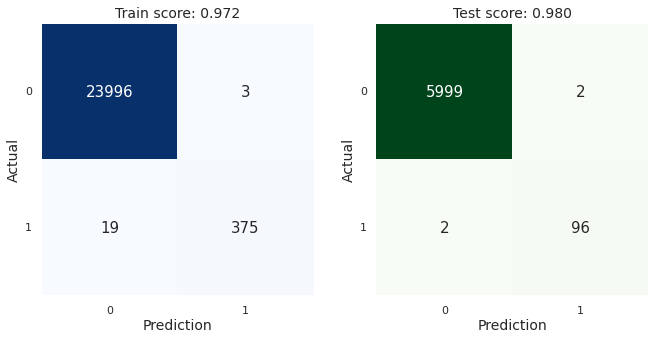

In [55]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

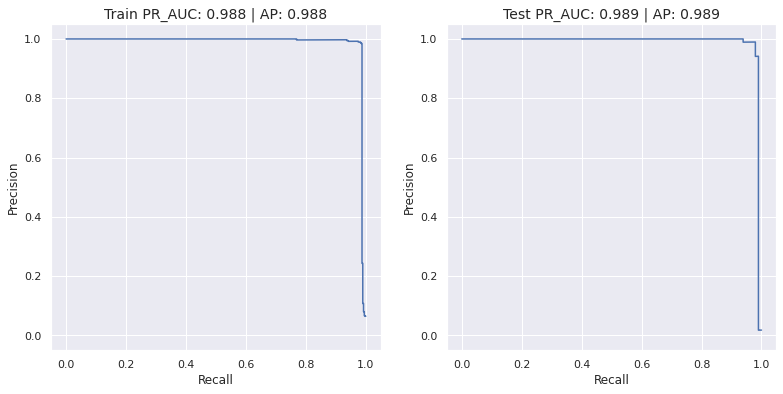

In [28]:
plot_pr_curve(X_train, y_train, X_test, y_test, model)

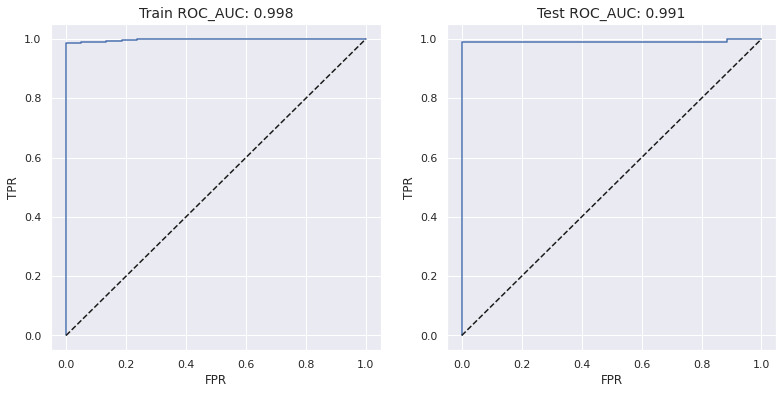

In [29]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

In [37]:
plot_association_matrix(datas, 'TARGET', categoric_col='auto') #Ini ga ada kolom yang kategorik, jadi error

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

In [57]:
datas_analisis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

datas_analisis['class'] = y_train
datas_analisis['prediksi'] = pred
datas_analisis['error'] = error
datas_analisis = datas_analisis[datas_analisis.error > 0]
datas_analisis

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,class,prediksi,error
30039,17187.0,1.088375,0.898474,0.394684,3.170258,0.175739,-0.221981,-0.022989,-0.010874,0.860044,-0.592473,1.072728,-2.547557,1.235950,-0.330306,-1.022354,0.335642,2.298998,-0.162096,-1.532707,-0.217358,-0.423554,-0.800852,0.077614,0.167608,0.350182,-0.118941,0.012948,0.054254,3.79,1,0,1
30156,47545.0,1.176716,0.557091,-0.490800,0.756424,0.249192,-0.781871,0.228750,-0.040840,-0.432111,-0.585778,2.281939,0.654567,-0.310379,-1.043705,0.513750,0.399178,1.143130,0.256014,-0.511210,-0.102772,-0.062166,-0.128168,-0.040176,0.110040,0.437891,0.368809,-0.018287,0.031173,0.76,1,0,1
30137,41791.0,-7.222731,6.155773,-10.826460,4.180779,-6.123555,-3.114136,-6.895112,5.161516,-2.516477,-6.403371,3.186058,-6.855571,-0.837723,-8.036615,0.956970,-4.557193,-7.654704,-2.588419,0.718555,0.818859,0.912700,-0.630358,0.190887,-0.061263,0.379775,-0.266845,1.193695,0.257468,99.99,1,0,1
30161,48533.0,1.243848,0.524526,-0.538884,1.209196,0.479538,-0.197429,0.049166,0.037792,0.128119,-0.552903,-0.668359,-0.818804,-0.883832,-0.994581,1.506849,0.624003,0.705794,0.524182,-0.731750,-0.171541,-0.051660,-0.084089,-0.192846,-0.917392,0.681953,-0.194419,0.045917,0.040136,1.00,1,0,1
30160,48380.0,-2.790771,-1.464269,1.031165,1.921356,-0.090014,-0.483871,0.780731,-0.348776,0.609133,0.225934,-1.064534,-0.787373,-1.576470,-0.126756,0.367012,-0.635322,0.327006,0.043816,1.403574,-1.376721,-0.392667,0.440020,0.777659,0.418552,0.244563,-0.159361,0.060540,0.356958,208.58,1,0,1
30056,25095.0,1.192396,1.338974,-0.678876,3.123672,0.643245,-1.184323,0.397586,-0.253499,0.411135,-0.859862,1.124059,-3.763874,0.367976,-0.971758,-0.013883,1.457579,2.611450,1.291955,-1.563815,-0.185455,-0.377503,-0.889597,-0.074208,0.035446,0.550578,-0.027171,-0.024921,0.073605,3.12,1,0,1
30085,30852.0,-2.830984,0.885657,1.199930,2.861292,0.321669,0.289966,1.767760,-2.451050,0.069736,3.245086,0.675288,-0.677096,-0.222741,-0.913787,1.603332,-1.024502,0.022045,-0.940685,0.484759,-1.016923,0.546589,0.334971,0.172106,0.623590,-0.527114,-0.079215,-2.532445,0.311177,104.81,1,0,1
30157,47826.0,-0.887287,1.390002,1.219686,1.661425,1.009228,-0.733908,0.855829,0.000077,-1.275631,-0.433394,0.141179,-0.460348,-0.367868,-1.168339,0.152108,0.882232,0.601805,-0.304092,-2.191764,-0.268347,-0.083734,-0.346930,-0.050619,0.231044,-0.450760,-0.376205,0.034504,0.157775,7.58,1,0,1
30057,25198.0,-15.903635,10.393917,-19.133602,6.185969,-12.538021,-4.027030,-13.897827,10.662252,-2.844954,-9.668789,7.394419,-11.635630,1.423277,-8.640459,-0.674720,-7.695569,-13.684140,-4.777406,1.268343,1.501565,1.577548,-1.280137,-0.601295,0.040404,0.995502,-0.273743,1.688136,0.527831,99.99,1,0,1
30000,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,0,1


In [36]:
datas.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
param = {
    'algo__gamma': np.logspace(-3, 3, 7),
    'algo__C': np.logspace(-3, 3, 7),
    'algo__class_weight':[
    {0: 0.1, 1:0.9},
    {0: 0.05, 1:0.95},
    {0: 0.25, 1:0.75}
    ]    
}

model = GridSearchCV(pipeline, param_grid=gsp.svm_params, cv=3, scoring='f1', verbose=1)
model.fit(X_train, y_train)

In [ ]:
model.score(X_train, y_train), model.score(X_test, y_test), model.best_params_

(0.980595084087969,
 0.9896907216494846,
 {'algo__C': 1000.0, 'algo__gamma': 0.001})

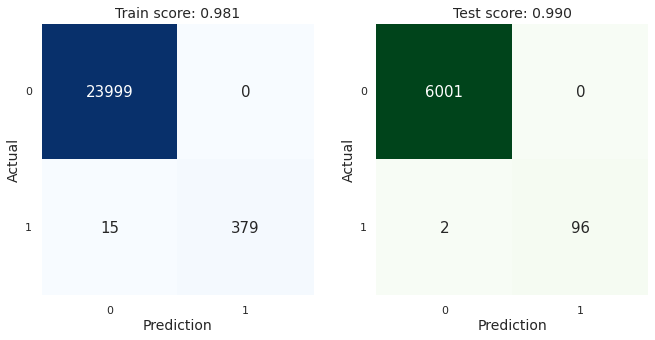

In [ ]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)